<a href="https://colab.research.google.com/github/ILYSHI/Neuronets/blob/main/CIFAR_10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import random
import numpy as np

random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic = True

In [2]:
import torchvision.datasets
CIFAR10_train  = torchvision.datasets.CIFAR10('./',download = True, train = True)
CIFAR10_test = torchvision.datasets.CIFAR10('./',download = True, train = False)

Extracting ./cifar-10-python.tar.gz to ./
Files already downloaded and verified


In [3]:
X_train = torch.FloatTensor(CIFAR10_train.data)
y_train = torch.LongTensor(CIFAR10_train.targets)
X_test = torch.FloatTensor(CIFAR10_test.data)
y_test = torch.LongTensor(CIFAR10_test.targets)

In [4]:
len(y_train), len(y_test)

(50000, 10000)

In [5]:
X_train.shape

torch.Size([50000, 32, 32, 3])

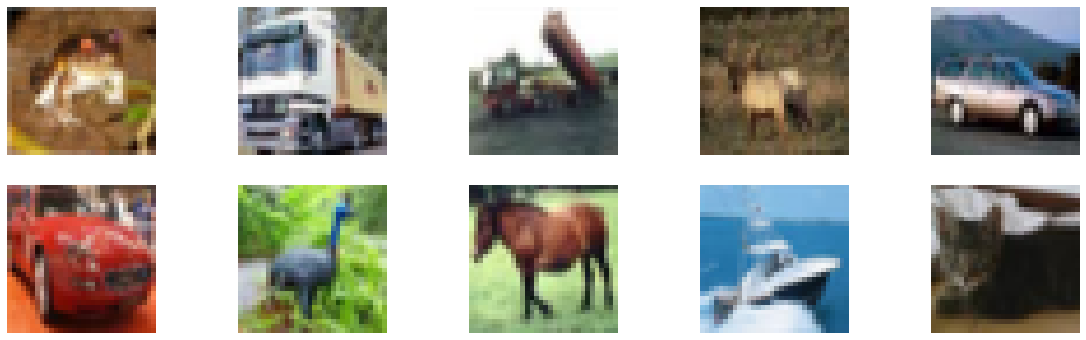

In [6]:
import matplotlib.pyplot as plt
n_images = 10
plt.figure(figsize=(20,6))
for i in range(n_images):
  plt.subplot(2,5,i+1)
  plt.axis('off')
  plt.imshow(X_train[i]/255)

In [7]:
CIFAR10_train.classes

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

In [8]:
X_train.shape

torch.Size([50000, 32, 32, 3])

In [9]:
# Конвертация для Pytorch (канал должен идти на 1 месте)
X_train = X_train.permute(0,3,1,2)
X_test = X_test.permute(0,3,1,2)

In [10]:
X_train.shape

torch.Size([50000, 3, 32, 32])

In [55]:
X_train = X_train/255
X_test = X_test/255

In [11]:
class LeNet5(torch.nn.Module):
  def __init__(self,
               activation='tanh',
               pooling='avg',
               conv_size=5,
               use_batch_norm=False):
    super(LeNet5,self).__init__()
    self.conv_size = conv_size
    self.use_batch_norm = use_batch_norm
    
    if activation == 'tanh':
      activation_function = torch.nn.Tanh()
    elif activation == 'relu':
      activation_function = torch.nn.ReLU()
    else:
      raise NotImplementedError

    if pooling == 'avg':
      pooling_layer = torch.nn.AvgPool2d(kernel_size=2, stride=2)
    elif pooling == 'max':
      pooling_layer = torch.nn.MaxPool2d(kernel_size=2, stride=2)
    else:
      raise NotImplementedError

    if conv_size == 5:
      self.conv1 = torch.nn.Conv2d(in_channels=3, out_channels=8, kernel_size=5, padding=0)
      self.conv2 = torch.nn.Conv2d(in_channels=8, out_channels=32, kernel_size=5, padding=0)
    elif conv_size == 3:
      self.conv1 = torch.nn.Sequential(
          torch.nn.Conv2d(in_channels=3, out_channels=6, kernel_size=3, padding=0),
          torch.nn.Conv2d(in_channels=6, out_channels=8, kernel_size=3, padding=0)
      )
      self.conv2 = torch.nn.Sequential(
          torch.nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, padding=0),
          torch.nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=0)
      )
    else:
      raise NotImplementedError

    # 1 слой (Сверточный)
    # self.conv1 = torch.nn.Conv2d(in_channels=1, out_channels=6, kernel_size=3, padding=2) #28х28 - 30х30
    self.act1 = activation_function
    self.pool1 = pooling_layer
    # 2 слой (Сверточный)

    # self.conv2 = torch.nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, padding=0) # 14х14 - 12x12
    self.act2 = activation_function
    self.bn2 = torch.nn.BatchNorm2d(num_features=32)
    self.pool2 = pooling_layer #10х10 - 5х5

    # 3 слой (полносвязный)

    self.fc1 = torch.nn.Linear(5*5*32,120)
    self.act3 = activation_function

    # 4 слой (полносвязный)

    self.fc2 = torch.nn.Linear(120,84)
    self.act4 = activation_function

    # 5 слой (полносвязный, выходной)

    self.fc3 = torch.nn.Linear(84,10)


  def forward(self,x):
    x = self.conv1(x)
    x = self.act1(x)
    x = self.pool1(x)

    x = self.conv2(x)
    x = self.act2(x)
    if self.use_batch_norm:
      x = self.bn2(x)
    x = self.pool2(x)

    x = x.view(x.size(0),x.size(1)* x.size(2) * x.size(3)) # 1х5х5х32 ==> 1х800

    x = self.fc1(x)
    x = self.act3(x)

    x = self.fc2(x)
    x = self.act4(x)

    x = self.fc3(x)

    return x 


## Инициализация сети

In [12]:
lenet_old = LeNet5()
lenet_upd = LeNet5(activation='relu',
               pooling='max',
               conv_size=3,
               use_batch_norm=True)

In [13]:
device = torch.device('cuda:0')

In [14]:
lenet_old = lenet_old.to(device) # Перенос сети на GPU

In [15]:
lenet_upd = lenet_upd.to(device)

In [17]:
batch_size = 100

In [56]:
X_test = X_test.to(device)
y_test = y_test.to(device)

In [73]:
import sys
def train(net,epochs=15,optimizer='Adam',batch_norm=False,continue_train = False, acc=None, losses=None):
  if continue_train:
    test_accuracy_history = acc
    test_loss_history = losses
  else:
    test_accuracy_history = []
    test_loss_history = []
  loss = torch.nn.CrossEntropyLoss()
  if optimizer == 'Adam':
    optimizer = torch.optim.Adam(net.parameters(),lr = 1.0e-3)
  else: optimizer = torch.optim.SGD(net.parameters(),momentum = 0.9,lr = 1.0e-3)

  for epoch in range(epochs):
    order = np.random.permutation(len(X_train))
    for start_index in range(0,len(X_train),batch_size):
        optimizer.zero_grad()
        if batch_norm:
          net.train()
        batch_indexes = order[start_index:start_index+batch_size]
        X_batch = X_train[batch_indexes].to(device)
        y_batch = y_train[batch_indexes].to(device)
        preds = net.forward(X_batch)
        loss_val = loss(preds,y_batch)
        loss_val.backward()
        optimizer.step()
    if batch_norm:
      net.eval()
    with torch.no_grad():
      test_preds = net.forward(X_test)
      test_loss_history.append(loss(test_preds, y_test).data.cpu())
      accuracy = (test_preds.argmax(dim=1) == y_test).float().mean().data.cpu()
      test_accuracy_history.append(accuracy)
      sys.stdout.write('\rProgress: '+str((epoch+1)/epochs*100))     
  del net
  return (test_accuracy_history,test_loss_history)



# CIFARNet

In [20]:
class CIFARNet(torch.nn.Module):
  def __init__(self, use_batch_norm=False):
    super(CIFARNet,self).__init__()
    self.use_batch_norm = use_batch_norm
    
    # if activation == 'tanh':
    #   activation_function = torch.nn.Tanh()
    # elif activation == 'relu':
    #   activation_function = torch.nn.ReLU()
    # else:
    #   raise NotImplementedError

    # if pooling == 'avg':
    #   pooling_layer = torch.nn.AvgPool2d(kernel_size=2, stride=2)
    # elif pooling == 'max':
    #   pooling_layer = torch.nn.MaxPool2d(kernel_size=2, stride=2)
    # else:
    #   raise NotImplementedError

    self.batch_norm0 = torch.nn.BatchNorm2d(3)

    # 1 слой (Сверточный)
    self.conv1 = torch.nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1) #32х32 - 32х32
    self.act1 = torch.nn.ReLU()
    self.batch_norm1 = torch.nn.BatchNorm2d(16)
    self.pool1 = torch.nn.MaxPool2d(2,2)
    # 2 слой (Сверточный)

    self.conv2 = torch.nn.Conv2d(16,32,3,padding=1) #16х16 - 16х16
    self.act2 = torch.nn.ReLU()
    self.batch_norm2 = torch.nn.BatchNorm2d(32)
    self.pool2 = torch.nn.MaxPool2d(2,2)
    # 3 слой (сверточный)
    self.conv3 = torch.nn.Conv2d(32,64,3,padding=1) #8х8 -8х8
    self.act3 = torch.nn.ReLU()
    self.batch_norm3 = torch.nn.BatchNorm2d(64)

    # 4 слой (полносвязный)
    self.fc1 = torch.nn.Linear(8*8*64,256)
    self.act4 = torch.nn.ReLU()
    self.batch_norm4 = torch.nn.BatchNorm1d(256)

    # 5 слой (полносвязный)
    self.fc2 = torch.nn.Linear(256,64)
    self.act5 = torch.nn.ReLU()
    self.batch_norm5 = torch.nn.BatchNorm1d(64)
    
    # 6 слой (полносвязный, выходной)
    self.fc3 = torch.nn.Linear(64,10)


  def forward(self,x):
    x = self.batch_norm0(x)

    x = self.conv1(x)
    x = self.act1(x)
    x = self.batch_norm1(x)
    x = self.pool1(x)

    x = self.conv2(x)
    x = self.act2(x)
    x = self.batch_norm2(x)
    x = self.pool2(x)

    x = self.conv3(x)
    x = self.act3(x)
    x = self.batch_norm3(x)

    x = x.view(x.size(0),x.size(1)* x.size(2) * x.size(3)) # 1х8х8x64 ==> 1х4096

    x = self.fc1(x)
    x = self.act4(x)
    x = self.batch_norm4(x)

    x = self.fc2(x)
    x = self.act5(x)
    x = self.batch_norm5(x)

    x = self.fc3(x)

    return x 


In [21]:
cifarnet = CIFARNet()
cifarnet = cifarnet.to(device)

In [40]:
accuracies = dict()
losses = dict()

acc_lenet_old, loss_lenet_old = train(net=lenet_old,epochs=30, batch_norm=False)
acc_lenet_upd, loss_lenet_upd = train(epochs=30,net=lenet_upd, batch_norm=True)
acc_cifar, loss_cifar = train(epochs=30,net=cifarnet,batch_norm=True)
accuracies['lenet_old'] = acc_lenet_old
accuracies['lenet_upd'] = acc_lenet_upd
accuracies['cifar'] = acc_cifar

losses['lenet_old'] = loss_lenet_old
losses['lenet_upd'] = loss_lenet_upd
losses['cifar'] = loss_cifar


KeyboardInterrupt: ignored

In [22]:
def plotter(accuracies, losses):
  # Функция вывода данных
  plt.figure(figsize=(15,6))
  plt.subplot(1,2,1)
  for label,accuracy in accuracies.items():
    plt.plot(accuracy,label=label)
  plt.legend()
  plt.title('Accuracy')

  plt.subplot(1,2,2)
  for label,loss in losses.items():
    plt.plot(loss,label=label)
  plt.legend()
  plt.title('Loss')

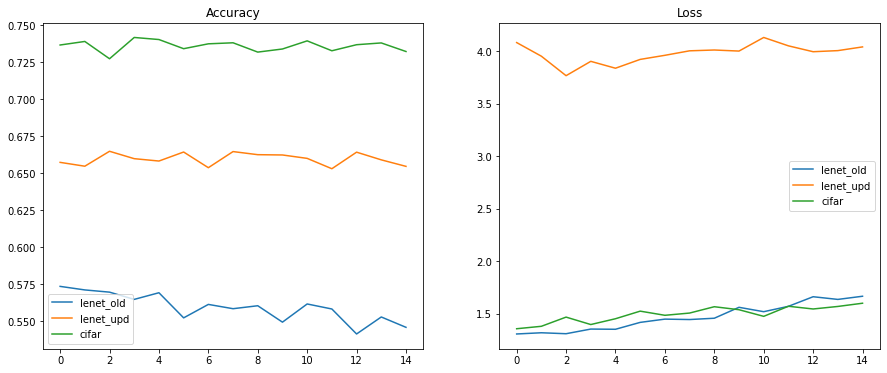

In [60]:
# Вывод графиков
plotter(accuracies, losses)

# Построение сети RESNET18

In [63]:
from torchvision.models import resnet18

In [64]:
myresnet18 = resnet18().to(device)

In [67]:
#acc_resnet18, loss_resnet18 = train(myresnet18, batch_norm=True)
accuracies = dict()
losses = dict()
accuracies['resnet18'] = acc_resnet18
losses['resnet18'] = loss_resnet18

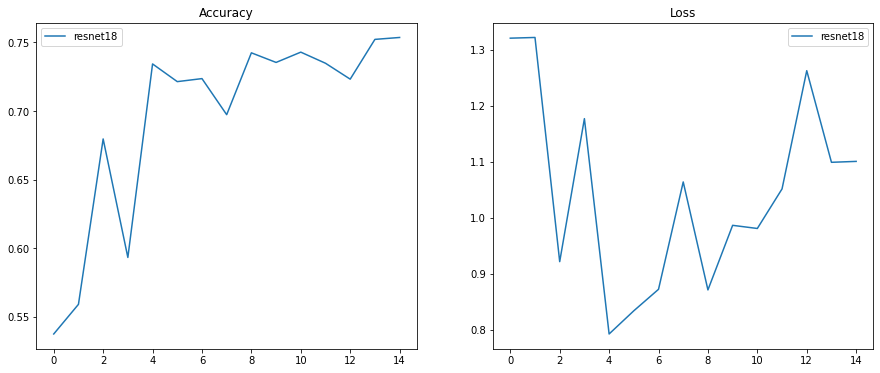

In [68]:
# Вывод графиков
plotter(accuracies, losses)

In [84]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as init

class LambdaLayer(nn.Module):
    def __init__(self, lambd):
        super(LambdaLayer, self).__init__()
        self.lambd = lambd
    def forward(self, x):
        return self.lambd(x)

class BasicBlock(nn.Module):
  expansion = 1

  def __init__(self, in_planes, out_planes, stride = 1, batch_norm = True,drop_out=0):
    super(BasicBlock, self).__init__()
    self.batch_norm = batch_norm
    self.drop_out = drop_out
    self.conv1 = nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride, padding=1, bias=False)
    self.bn1 = nn.BatchNorm2d(out_planes)
    if self.drop_out:
      self.do1 = nn.Dropout2d(p=p_DropOut)
    self.conv2 = nn.Conv2d(out_planes, out_planes, kernel_size=3, stride=1, padding=1, bias=False)
    self.bn2 = nn.BatchNorm2d(out_planes)
    if self.drop_out:
      self.do2 = nn.Dropout2d(p=p_DropOut)
    self.shortcut = LambdaLayer(lambda x: F.pad(x[:, :, ::2, ::2], 
                                                (0, 0, 0, 0, planes//4, planes//4), "constant", 0))
  def forward(self, x):
        if self.drop_out:
            x = F.relu(self.do1(self.bn1(self.conv1(x))))
            x = self.do2(self.bn2(self.conv2(out)))
        elif not self.batch_norm:
            x = F.relu(self.conv1(x))
            x = self.conv2(x)
        else: # default
            x = F.relu(self.bn1(self.conv1(x)))
            out = self.bn2(self.conv2(x))
        return x
  
# Класс Resnet c произвольным числом блоков:

class ResNet(nn.Module):
  def __init__(self, block, num_blocks, num_classes=10,  batch_norm=True,drop_out = 0):
    super(ResNet, self).__init__()
    self.batch_norm = batch_norm
    self.in_planes = 16
    self.drop_out = drop_out
    self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1, bias=False)
    self.bn1 = nn.BatchNorm2d(16)
    self.do1 = nn.Dropout2d(p=self.drop_out)
    self.layer1 = self._make_layer(block, 16, num_blocks[0], stride=1)
    self.layer2 = self._make_layer(block, 32, num_blocks[1], stride=2)
    self.layer3 = self._make_layer(block, 64, num_blocks[2], stride=2)
    self.linear = nn.Linear(64, num_classes)

  def _make_layer(self, block, out_planes, num_blocks, stride):
    strides = [stride] + [1]*(num_blocks-1)
    layers = []
    for stride in strides:
            layers.append(block(self.in_planes, out_planes, stride, batch_norm=self.batch_norm))
            self.in_planes = out_planes * block.expansion    
    return nn.Sequential(*layers)
  def forward(self, x):
        if self.drop_out:
            x = F.relu(self.do1(self.bn1(self.conv1(x))))
        elif  not self.batch_norm:
            x = F.relu(self.conv1(x))
        else: #Default
            x = F.relu(self.bn1(self.conv1(x)))

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = F.avg_pool2d(x, x.size()[3])
        x = x.view(x.size(0), -1)
        x = self.linear(x)
        return x


def resnet20(batch_norm=True,drop_out=0):
  return ResNet(BasicBlock, [3, 3, 3], batch_norm = True,drop_out=drop_out)

def resnet45(batch_norm=True):
    return ResNet(BasicBlock, [7, 7, 7], batch_norm = True)
def resnet68(batch_norm=True):
    return ResNet(BasicBlock, [11, 11, 11], batch_norm = True)
        
    

  

In [87]:
myresnet20 = resnet20().to(device)
myresnet45 = resnet45().to(device)
myresnet20_dp015 = resnet20(batch_norm=True,drop_out=0.15).to(device)

In [75]:
batch_size = 100

In [88]:
acc_resnet20_dp015, loss_resnet20_dp015 = train(myresnet20_dp015, batch_norm=True)
accuracies['resnet20_dp015'] = acc_resnet20_dp015
losses['resnet20_dp015'] = loss_resnet20_dp015

Progress: 100.0

In [77]:
acc_resnet45, loss_resnet45 = train(myresnet45, batch_norm=True)
accuracies['resnet45'] = acc_resnet45
losses['resnet45'] = loss_resnet45

Progress: 100.0

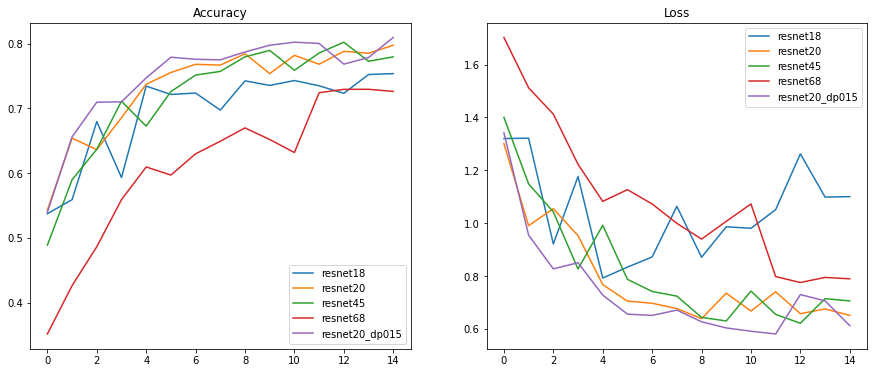

In [89]:
# Вывод графиков
plotter(accuracies, losses)

In [80]:
myresnet68 = resnet68().to(device)

In [81]:
acc_resnet68, loss_resnet68 = train(myresnet68, batch_norm=True)
accuracies['resnet68'] = acc_resnet68
losses['resnet68'] = loss_resnet68

Progress: 100.0

In [98]:
import pickle
data = (accuracies,losses)
with open('data.pickle','wb') as f:
  pickle.dump(data,f)

In [103]:
with open ('data.pickle','rb') as f:
  read_acc, read_loss = pickle.load(f)

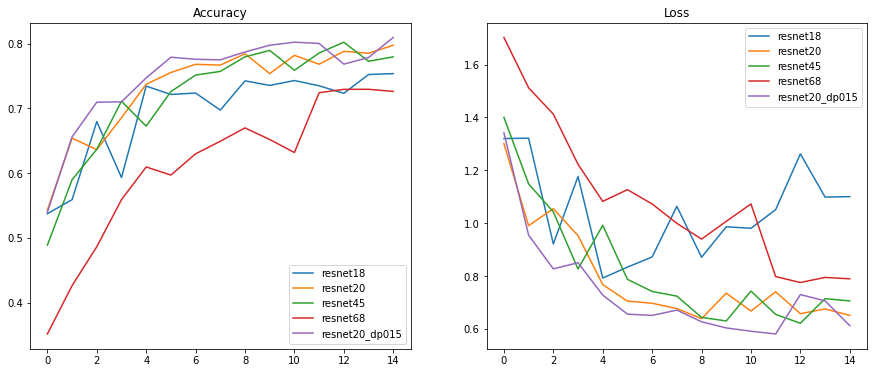

In [104]:
# Вывод графиков
plotter(read_acc, read_loss)

# Проверка лучшей активирующей функции

In [95]:
import torch
import numpy as np

seed = int(input())
np.random.seed(seed)
torch.manual_seed(seed)

NUMBER_OF_EXPERIMENTS = 200

class SimpleNet(torch.nn.Module):
    def __init__(self, activation):
        super().__init__()

        self.activation = activation
        self.fc1 = torch.nn.Linear(1, 1, bias=False)  # one neuron without bias
        self.fc1.weight.data.fill_(1.)  # init weight with 1
        self.fc2 = torch.nn.Linear(1, 1, bias=False)
        self.fc2.weight.data.fill_(1.)
        self.fc3 = torch.nn.Linear(1, 1, bias=False)
        self.fc3.weight.data.fill_(1.)

    def forward(self, x):
        x = self.activation(self.fc1(x))
        x = self.activation(self.fc2(x))
        x = self.activation(self.fc3(x))
        return x

    def get_fc1_grad_abs_value(self):
        return torch.abs(self.fc1.weight.grad)

def get_fc1_grad_abs_value(net, x):
    output = net.forward(x)
    output.backward()  # no loss function. Pretending that we want to minimize output
                       # In our case output is scalar, so we can calculate backward
    fc1_grad = net.get_fc1_grad_abs_value().item()
    net.zero_grad()
    return fc1_grad

functions = [torch.nn.ELU,
             torch.nn.ReLU, 
             torch.nn.LeakyReLU,
             torch.nn.Sigmoid, 
             torch.nn.Tanh,
             torch.nn.Hardtanh,
             torch.nn.LogSigmoid,
             torch.nn.PReLU,
             torch.nn.ReLU6,
             torch.nn.RReLU,
             torch.nn.SELU,
             torch.nn.CELU,
             torch.nn.Softplus,
             torch.nn.Softshrink,
             torch.nn.Softsign,
             torch.nn.Tanhshrink,
             torch.nn.Hardshrink
             ]
Results = dict()
for function in functions:
  np.random.seed(seed)
  torch.manual_seed(seed)
  activation =  function()
  net = SimpleNet(activation=activation)
  fc1_grads = []
  for x in torch.randn((NUMBER_OF_EXPERIMENTS, 1)):
    fc1_grads.append(get_fc1_grad_abs_value(net, x))
  Results[function] = np.mean(fc1_grads)

print(*Results.items(),sep='\n')

# Проверка осуществляется автоматически, вызовом функции:
# print(np.mean(fc1_grads))
# (раскомментируйте, если решаете задачу локально)

KeyboardInterrupt: ignored